In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

Epoch 1/5
782/782 [==============================] - 123s 155ms/step - loss: 0.3690 - accuracy: 0.8366 - val_loss: 0.3041 - val_accuracy: 0.8697
Epoch 2/5
782/782 [==============================] - 125s 160ms/step - loss: 0.2357 - accuracy: 0.9085 - val_loss: 0.3228 - val_accuracy: 0.8635
Epoch 3/5
782/782 [==============================] - 123s 157ms/step - loss: 0.1821 - accuracy: 0.9322 - val_loss: 0.3451 - val_accuracy: 0.8612
Epoch 4/5
782/782 [==============================] - 130s 167ms/step - loss: 0.1277 - accuracy: 0.9562 - val_loss: 0.4151 - val_accuracy: 0.8557
Epoch 5/5
782/782 [==============================] - 63s 81ms/step - loss: 0.4973 - accuracy: 0.8526
Test Accuracy: 85.26%


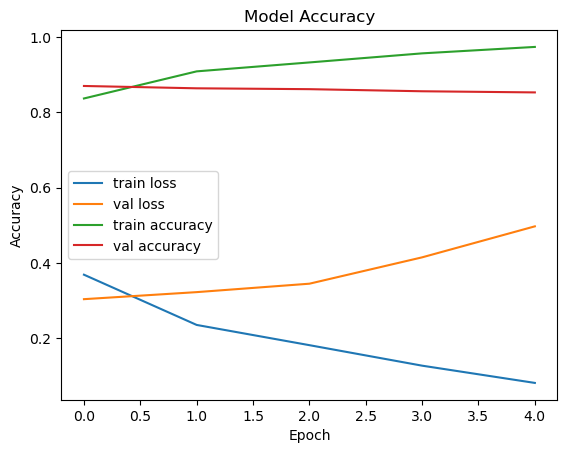

In [3]:
# Шаг 1: Загрузка данных
def load_data(data_dir):
    texts = []
    labels = []
    for label, subdir in enumerate(['pos', 'neg']):  # 0 для отрицательных, 1 для положительных
        subdir_path = os.path.join(data_dir, subdir)
        for filename in os.listdir(subdir_path):
            with open(os.path.join(subdir_path, filename), encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(label)
    return texts, labels

# Путь к данным
train_dir = 'C:/Users/user/Desktop/IMDb Reviews/aclImdb/train'
test_dir = 'C:/Users/user/Desktop/IMDb Reviews/aclImdb/test'

# Загрузка данных
train_texts, train_labels = load_data(train_dir)
test_texts, test_labels = load_data(test_dir)

# Шаг 2: Предобработка текста
def preprocess_text(text):
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r'http\S+', '', text)  # Убираем ссылки
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Убираем все кроме букв и пробелов
    return text

# Применяем предобработку к текстам
train_texts = [preprocess_text(text) for text in train_texts]
test_texts = [preprocess_text(text) for text in test_texts]

# Шаг 3: Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Преобразуем метки в массивы NumPy
y_train = np.array(train_labels)
y_test = np.array(test_labels)

# Преобразуем разреженную матрицу в плотную
X_train = X_train.toarray()
X_test = X_test.toarray()

# Шаг 4: Создание нейронной сети
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))  # Входной слой
model.add(Dropout(0.5))  # Для предотвращения переобучения
model.add(Dense(64, activation='relu'))  # Скрытый слой
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Выходной слой для бинарной классификации

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Шаг 5: Обучение модели
checkpoint = ModelCheckpoint('C:/Users/user/Desktop/IMDb Reviews/results/best_model.h5', 
                             save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Шаг 6: Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

# Сохранение результатов
# График потерь
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('C:/Users/user/Desktop/IMDb Reviews/results/loss_plot.png')

# График точности
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('C:/Users/user/Desktop/IMDb Reviews/results/accuracy_plot.png')

# Сохранение модели
model.save('C:/Users/user/Desktop/IMDb Reviews/results/sentiment_model.h5')